In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import json
import time
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

## Modelling Parameters

In [7]:
# Input dim
input_dim = 2
# Number of hidden nodes
hidden_dim = 32
# Number of output nodes
output_dim = 2
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = True

batch_size = 32
# Percentage of training data
learning_rate = 0.001

device = "cuda"

## n-copy task dataset

The entire dataset comprises of the binary representation of all numbers uptil a range defined. The binary sequence from left to right (most significant to least significant) is the input. The target is just the reverse sequence.

In [58]:
from seq_seq_different import create_ncopy_task

train_loader, test_loader, valid_loader = create_ncopy_task(sequence_length=20, 
                                       n_copy=10,
                                       batch_size=batch_size, 
                                       train_test_ratio=0.9, 
                                       train_valid_ratio=0.7)

## Our implementation

In [9]:
from seq_seq_different import LSTMSeq2SeqDifferent

our = LSTMSeq2SeqDifferent(input_dim, hidden_dim, output_dim, bidirectional=bidirectional, 
                           layers=layers, layernorm=layernorm).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(our.count_parameters()))
for name, param in our.named_parameters():
    print("{:<40}: {}".format(name, param.shape))

Our implementation
# of parameters: 27522
encoder.model.0.weights                 : torch.Size([34, 128])
encoder.model.0.bias                    : torch.Size([128])
encoder.model.0.ln_gates.weight         : torch.Size([128])
encoder.model.0.ln_gates.bias           : torch.Size([128])
encoder.model.0.ln_candidate.weight     : torch.Size([32])
encoder.model.0.ln_candidate.bias       : torch.Size([32])
encoder.model_rev.0.weights             : torch.Size([34, 128])
encoder.model_rev.0.bias                : torch.Size([128])
encoder.model_rev.0.ln_gates.weight     : torch.Size([128])
encoder.model_rev.0.ln_gates.bias       : torch.Size([128])
encoder.model_rev.0.ln_candidate.weight : torch.Size([32])
encoder.model_rev.0.ln_candidate.bias   : torch.Size([32])
decoder.model.0.weights                 : torch.Size([66, 256])
decoder.model.0.bias                    : torch.Size([256])
decoder.model.0.ln_gates.weight         : torch.Size([256])
decoder.model.0.ln_gates.bias           : torch.Si

Beginning training model with 27522 parameters
Files will be saved in: dump/Seq2SeqDifferent/

Epoch #1: Batch 99/99 -- Loss = 0.6887339353561401; Time taken: 0.5920343399047852s
Epoch #1: Average loss is 0.6926533176441385
Epoch #1: Train F1 is 0.5757900511603578
Epoch #1: Validation F1 is 0.5774969334274987
Time taken for epoch: 93.02748584747314s

Epoch #2: Batch 99/99 -- Loss = 0.6749377846717834; Time taken: 0.5859098434448242s
Epoch #2: Average loss is 0.6819535921318363
Time taken for epoch: 61.62702798843384s

Epoch #3: Batch 99/99 -- Loss = 0.6899448037147522; Time taken: 0.6385793685913086s
Epoch #3: Average loss is 0.6916364900993578
Time taken for epoch: 63.64527201652527s

Epoch #4: Batch 99/99 -- Loss = 0.6920671463012695; Time taken: 0.6090002059936523s
Epoch #4: Average loss is 0.6929282154699768
Time taken for epoch: 67.06329345703125s

Epoch #5: Batch 99/99 -- Loss = 0.6915028095245361; Time taken: 0.7010986804962158s
Epoch #5: Average loss is 0.6925590381477819
Epoch

Epoch #43: Batch 99/99 -- Loss = 0.31360581517219543; Time taken: 0.6063954830169678s
Epoch #43: Average loss is 0.3139691211358465
Time taken for epoch: 59.5839467048645s

Epoch #44: Batch 99/99 -- Loss = 0.313556969165802; Time taken: 0.5881121158599854s9s
Epoch #44: Average loss is 0.31374749601489366
Time taken for epoch: 58.76855802536011s

Epoch #45: Batch 99/99 -- Loss = 0.31347888708114624; Time taken: 0.5897963047027588s
Epoch #45: Average loss is 0.3135480179329111
Epoch #45: Train F1 is 0.9998897885057397
Epoch #45: Validation F1 is 0.9996616358234706
Time taken for epoch: 88.01975202560425s

Epoch #46: Batch 99/99 -- Loss = 0.3134467601776123; Time taken: 0.5915350914001465ss
Epoch #46: Average loss is 0.31349956567841347
Time taken for epoch: 59.395484924316406s

Epoch #47: Batch 99/99 -- Loss = 0.3134211003780365; Time taken: 0.5983166694641113ss
Epoch #47: Average loss is 0.313467185605656
Time taken for epoch: 58.99990200996399s

Epoch #48: Batch 99/99 -- Loss = 0.31340

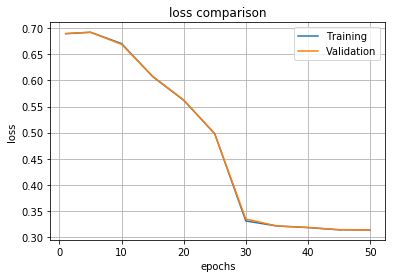

In [10]:
from seq_seq_different import Seq2SeqDifferent

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our.parameters(), lr=learning_rate)

task_our = Seq2SeqDifferent(model=our, optimizer=optimizer, loss_fn=loss_fn, device=device)

our, our_stats = task_our.train(50, train_loader, valid_loader, teacher_forcing=0.5, freq=5,
                                out_dir='dump/Seq2SeqDifferent/')

In [ ]:
# our.load("dump/Seq2SeqDifferent/model_epoch_45.pkl")

In [14]:
our_f1 = task_our.evaluate(test_loader, True)
print(our_f1)

Confusion Matrix: 
 [[50220     0]
 [    0 49780]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50220
           1       1.00      1.00      1.00     49780

   micro avg       1.00      1.00      1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

(1.0, 0.3134151063859463)


In [15]:
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    break
print(x.shape, y.shape)
h = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
c = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
o = our(x, y, h, c)

torch.Size([20, 32, 2]) torch.Size([200, 32, 2])


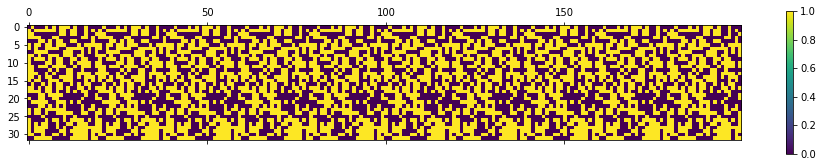

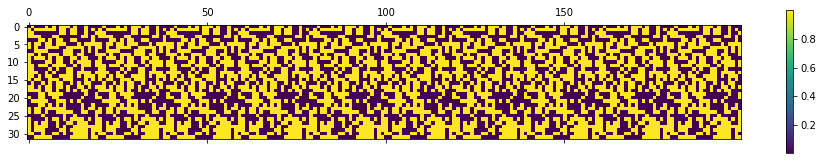

In [18]:
plt.matshow(torch.transpose(torch.argmax(y,2), 1, 0).detach().cpu().numpy())
plt.colorbar();
plt.matshow(torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy())
plt.colorbar();

# plt.matshow(np.bitwise_xor(torch.transpose(torch.argmax(y[:60],2), 1, 0).detach().cpu().long().numpy(), torch.transpose(o[:60,:,1], 1, 0).detach().cpu().long().numpy()))

### Test with longer output

In [59]:
long_output_train_loader, \
long_output_test_loader, \
long_output_val_loader = create_ncopy_task(sequence_length=20, 
                                           n_copy=20,
                                           batch_size=batch_size, 
                                           train_test_ratio=0.9, 
                                           train_valid_ratio=0.8)


our_f1 = task_our.evaluate(long_output_test_loader, True)
print(our_f1)

for x, y in long_output_test_loader:
    x = x.to(device)
    y = y.to(device)
    break

h = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
c = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
o = our(x, y, h, c)

Confusion Matrix: 
 [[100258     22]
 [    76  99644]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    100280
           1       1.00      1.00      1.00     99720

   micro avg       1.00      1.00      1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000

(0.9995084910675774, 0.31385323964059353)


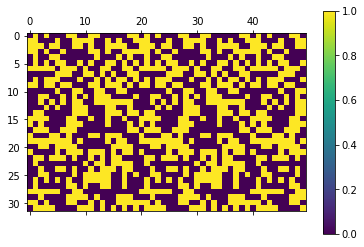

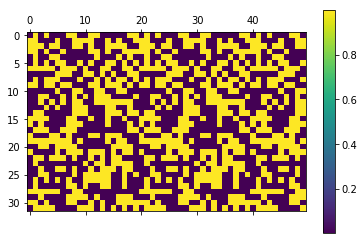

In [60]:
plt.matshow(torch.transpose(torch.argmax(y[-50:],2), 1, 0).detach().cpu().numpy())
plt.colorbar();
plt.matshow(torch.transpose(o[-50:,:,1], 1, 0).detach().cpu().numpy())
plt.colorbar();

### Test with longer input

In [61]:
long_input_train_loader, \
long_input_test_loader, \
long_input_val_loader = create_ncopy_task(sequence_length=25, 
                                           n_copy=10,
                                           batch_size=batch_size, 
                                           train_test_ratio=0.9, 
                                           train_valid_ratio=0.8)


our_f1 = task_our.evaluate(long_input_test_loader, True)
print(our_f1)

for x, y in long_input_test_loader:
    x = x.to(device)
    y = y.to(device)
    break

h = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
c = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
o = our(x, y, h, c)

Confusion Matrix: 
 [[35752 26858]
 [26444 35946]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.57      0.57      0.57     62610
           1       0.57      0.58      0.57     62390

   micro avg       0.57      0.57      0.57    125000
   macro avg       0.57      0.57      0.57    125000
weighted avg       0.57      0.57      0.57    125000

(0.5742447721136795, 0.7386811599135399)


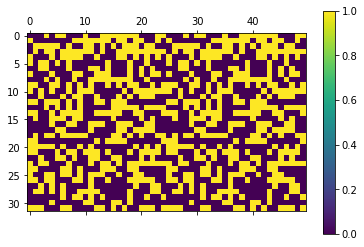

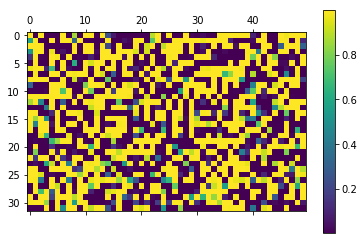

In [62]:
plt.matshow(torch.transpose(torch.argmax(y[-50:],2), 1, 0).detach().cpu().numpy())
plt.colorbar();
plt.matshow(torch.transpose(o[-50:,:,1], 1, 0).detach().cpu().numpy())
plt.colorbar();

## PyTorch implementation

In [ ]:
# class PyTorchBaseline(nn.Module):
#     """ LSTM Class for Sequence Labelling (many-to-many-different)

#     The class creates the LSTM architecture as specified by the parameters.
#     A fully connected layer is added to reduce the last hidden state to output_dim.

#     Parameters
#     ==========
#     vocab_len: int from imdb dataset
#     embed_dim: dimensions of the embeddings
#     hidden_dim: number of hidden nodes required
#     output_dim: numer of output nodes required (1 for sentiment analysis)
#     pretrained_vec: weights from imdb object
#     layers: number of LSTM cells to be stacked for depth
#     bidirectional: boolean
#     layernorm: boolean

#     """
#     def __init__(self, input_dim, hidden_dim, output_dim, layers=1,
#                  bidirectional=False, layernorm=False):
#         super().__init__()

#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.hidden_dim = hidden_dim
#         self.layers = layers
#         self.bidirectional = bidirectional
#         self.layernorm = layernorm

#         self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers,
#                          bidirectional=bidirectional) #, layernorm=layernorm)
#         if self.bidirectional:
#             self.decoder = nn.LSTM(input_size=output_dim, hidden_size=2 * hidden_dim, num_layers=layers,
#                                 bidirectional=False) #, layernorm=layernorm)
#             self.fc = nn.Linear(2 * hidden_dim, output_dim)
#         else:
#             self.decoder = nn.LSTM(input_size=output_dim, hidden_size=hidden_dim, num_layers=layers,
#                                 bidirectional=False) #, layernorm=layernorm)
#             self.fc = nn.Linear(hidden_dim, output_dim)
#         self.softmax = nn.Softmax(dim=2)

#     def forward(self, x, target, hidden_state, cell_state, teacher_forcing=0.5):
#         device = 'cpu'
#         if x.is_cuda:
#             device = 'cuda'
#         # encoding
#         _, (hidden_state, cell_state) = self.encoder(x, (hidden_state, cell_state))
#         batch_size = x.shape[1]
#         timesteps = target.shape[0]
#         x = torch.zeros(1, batch_size, self.output_dim).to(device)
#         output = torch.tensor([]).to(device)
#         if self.bidirectional:
#             # concatenating hidden states from two directions
#             hidden_state = torch.cat((hidden_state[:self.layers,:,:], 
#                                       hidden_state[self.layers:,:,:]), dim=2)
#             cell_state = torch.cat((cell_state[:self.layers,:,:], 
#                                     cell_state[self.layers:,:,:]), dim=2)
#         # decoding
#         for t in range(timesteps):           
#             x, (hidden_state, cell_state) = self.decoder(x, (hidden_state, cell_state))
#             x = self.softmax(self.fc(x))
#             output = torch.cat((output, x), dim=0)
#             choice = random.random() 
#             if choice < teacher_forcing:
#                 x = target[t].float().to(device)
#                 x = x.unsqueeze(0)
#             else:
#                 # converting x to a one-hot encoding
#                 x = torch.zeros(x.shape).to(device).scatter_(2, torch.argmax(x, -1, keepdim=True), 1)
#         return output

#     def save(self, file_path='./model.pkl'):
#         torch.save(self.state_dict(), file_path)

#     def load(self, file_path):
#         self.load_state_dict(torch.load(file_path))

#     def count_parameters(self):
#         tot_sum = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
#         tot_sum += sum(p.numel() for p in self.decoder.parameters() if p.requires_grad)
#         tot_sum += sum(p.numel() for p in self.fc.parameters() if p.requires_grad)
#         return tot_sum


In [ ]:
# pytorch = PyTorchBaseline(input_dim, hidden_dim, output_dim, layers, bidirectional).to(device)
# print(pytorch.count_parameters())
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(pytorch.parameters(), lr=learning_rate)

In [ ]:
# train_x = train_x.to(device)
# train_y = train_y.to(device)
# test_x = test_x.to(device)
# test_y = test_y.to(device)

# pytorch = train(pytorch, train_x, train_y, test_x, test_y, epochs=30, loss_fn=loss_fn, optimizer=optimizer, teacher_forcing=0.5)